# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science 

## Lab 3: kNN and Linear Regression

Student's version

**Harvard University**<br/>
**Fall 2021**<br/>
**Instructors**: Pavlos Protopapas and Natesh Pillai<br/>
**Lab Team**: Marios Mattheakis, Hayden Joy, Chris Gumb, and Eleni Kaxiras<br/>
**Authors**: Marios Mattheakis and Eleni Kaxiras
<hr style='height:2px'>

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("http://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

<a id=top></a>
## Learning Objectives

For this lab, our goal is for you to try out your first models, and specifically k-Nearest Neighbors (kNN) and Linear Regression. In the course thus far, we have discussed some aspects of dealing with data, including scraping data from the web, organizing it using dictionaries and Pandas dataframes, and visualizing it using Matplotlib. Now we're moving on to data modeling! We make models to fit the **training data** and predict on the **test data**. We will see what those two types of data are.

Specifically, our learning objectives are:
- [1 - Performing exploratory data analysis (EDA) on our dataset](#eda).
- [2 - Splitting this dataset into a training and test set](#split).
- [3 - Training you first models (kNN and Linear Regression) on your data using the `sklearn` library](#sklearn).
- Using these models to understand relationships between the response variable and the predictors (also called features).
- Evaluating model performance on the test set using metrics such as $R^2$ and MSE. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from pandas.api.types import CategoricalDtype
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import MinMaxScaler

from statsmodels.api import OLS
import statsmodels.api as sm

# uncomment to display full dataframe
# pd.set_option('display.max_rows', None)

<a class="anchor" id="eda"></a>
## 1 - The Bikeshare dataset and preliminary EDA

Our dataset was collected by the Capital Bikeshare program in Washington D.C (*source: [UCI repository](#https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset)*). It contains over two years of data on the total number of bike rentals per day, as well as 10 attributes describing the day and its weather (see below for a description). The dataset is provided in the file `bikeshare.csv`.

The task is to build a regression model to **predict the total number of bike rentals in a given day** (known as the response variable) based on attributes about the day (known as the features). Such a forecasting model would be useful in planning the number of bikes that need to be available in the system on any given day, and also in monitoring traffic in the city.

**Description of variables**

- season (1:winter, 2:spring, 3:summer, 4:fall) 
- month (1 through 12, with 1 denoting Jan)
- holiday (1 = the day is a holiday, 0 = otherwise, extracted from https://dchr.dc.gov/page/holiday-schedules)
- day_of_week (0 through 6, with 0 denoting Sunday)
- workingday (1 = the day is neither a holiday or weekend, 0 = otherwise)
- weather 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp (temperature in Celsius)
- atemp (apparent, or relative outdoor, or real feel temperature, in Celsius)
- humidity (relative humidity)
- windspeed (wind speed)
------------------------
- **count** (response variable i.e. total number of bike rentals on the day)

#### Load and inspect the BikeShare dataset

In [3]:
bikeshare = pd.read_csv('data/bikeshare.csv')
print(f'Length of Dataset: {bikeshare.shape[0]}')
display(bikeshare.head())

Length of Dataset: 731


,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
0,2,5,0,2,1,2,24.0,26.0,76.58,0.12,6073
1,4,12,0,2,1,1,15.0,19.0,73.38,0.17,6606
2,2,6,0,4,1,1,26.0,28.0,56.96,0.25,7363
3,4,12,0,0,0,1,0.0,4.0,58.63,0.17,2431
4,3,9,0,3,1,3,23.0,23.0,91.71,0.10,1996


In [4]:
bikeshare.columns

Index(['season', 'month', 'holiday', 'day_of_week', 'workingday', 'weather',
       'temp', 'atemp', 'humidity', 'windspeed', 'count'],
      dtype='object')

#### Let's check for missing values

It's always a good practice to check the types of your features and make sure they are what they are supposed to be. If not, we can cast them to the correct type using `.astype()`

In [5]:
bikeshare.isnull().sum()

season         0
month          0
holiday        0
day_of_week    0
workingday     0
weather        0
temp           0
atemp          0
humidity       0
windspeed      0
count          0
dtype: int64

#### Let's check the types of the features

It's always a good practice to check the types of your features and make sure they are what they are supposed to be. If not, we can cast them to the correct type using `.astype()`

In [6]:
bikeshare.dtypes

season           int64
month            int64
holiday          int64
day_of_week      int64
workingday       int64
weather          int64
temp           float64
atemp          float64
humidity       float64
windspeed      float64
count            int64
dtype: object

In [7]:
## here we designate the types that we want
# categorical variables
cat_type = CategoricalDtype(ordered=False)
cat_vars = ['weather', 'day_of_week','holiday', 'season', 'month','workingday', 'weather']
for var in cat_vars:
    bikeshare[var] = bikeshare[var].astype(cat_type)
# integer variables
int_vars = ['count']
for var in int_vars:
    bikeshare[var] = bikeshare[var].astype('int')

In [8]:
bikeshare.dtypes

season         category
month          category
holiday        category
day_of_week    category
workingday     category
weather        category
temp            float64
atemp           float64
humidity        float64
windspeed       float64
count             int64
dtype: object

In [9]:
## OPTIONAL for good housekeeping - make a dict with the feature descriptions
names_dict={'season' : 'Season (1 for spring, 2 for summer, 3 for fall, 4 for winter)',
                'month' : 'Month of the year (1 through 12, with 1 denoting Jan)',
                'holiday' : '1 = the day is a holiday, 0 = otherwise',
                'count' : 'Total number of bike rentals on the day',
                'temp' : 'Temperature (degrees C)'}
               
                 ##... fill out the rest of the features


## useful in explaining the features in plots, tables, etc.
print(names_dict['month'])

Month of the year (1 through 12, with 1 denoting Jan)


#### How many categories does `day_of_the_week` have?

In [10]:
# see how many categories we have
bikeshare['day_of_week'].unique()

[2, 4, 0, 3, 6, 5, 1]
Categories (7, int64): [0, 1, 2, 3, 4, 5, 6]

In [11]:
bikeshare[bikeshare.season==4].shape

(178, 11)

#### Example of why  `.groupby()` is powerfull

You can think of `.groupby()` and `agg` (aggregate) as a way to flatten a part of the DataFrame. Is we group by `month` and then aggreegate the values for each month we effectively flatten all the rows that are the same month together. When you flatten the DataFrame you need to specify **how** to aggregate the values, e.g. sum them up, count them, etc?
```
DataFrame.groupby(by=None, axis=0, level=None, as_index=True, sort=True, group_keys=True, squeeze=NoDefault.no_default, observed=False, dropna=True)
```

For more see: https://pandas.pydata.org/pandas-docs/stable/reference/groupby.html

In [16]:
bikeshare.sort_values(['season'], ascending=False).groupby('season', observed=True).head(2)

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
595,4,10,0,1,1,2,18.0,21.0,64.92,0.09,6778
211,4,12,0,1,1,2,9.0,14.0,82.71,0.06,3811
280,3,8,0,6,0,2,29.0,29.0,73.29,0.21,6299
520,3,8,0,5,1,2,29.0,30.0,61.50,0.07,7582
552,2,5,0,1,1,1,21.0,24.0,78.79,0.13,3958
652,2,4,0,4,1,2,16.0,19.0,75.67,0.18,5026
478,1,3,0,5,1,1,19.0,22.0,52.52,0.23,3239
87,1,2,1,1,0,2,4.0,7.0,60.50,0.31,1107


In [17]:
### very useful
import calendar
calendar.month_name[1]

'January'

In [21]:
bikeshare[['season','month','day_of_week', 'temp']]\
    .groupby('month', observed=True)\
    .agg({
        'day_of_week': 'size',
        'season': lambda x: ','.join(np.unique(x.astype(str))),
        'temp': 'mean'
    })


,day_of_week,season,temp
month,,,
1,62,1,-0.080645
2,57,1,3.912281
3,62,"1,2",9.580645
4,60,2,14.583333
5,62,2,22.532258
6,60,"2,3",28.150000
7,62,3,32.580645
8,62,3,29.629032
9,60,"3,4",23.850000


**Plot the count of bike rentals by month**

In [26]:
ave_rentals_month = bikeshare.groupby('month', observed=True)['count'].mean()
ave_rentals_month

month
1     2498.306452
2     2824.315789
3     3822.241935
4     4348.600000
5     5268.790323
6     5547.033333
7     5563.677419
8     5584.887097
9     5653.316667
10    5199.225806
11    4454.633333
12    3781.741935
Name: count, dtype: float64

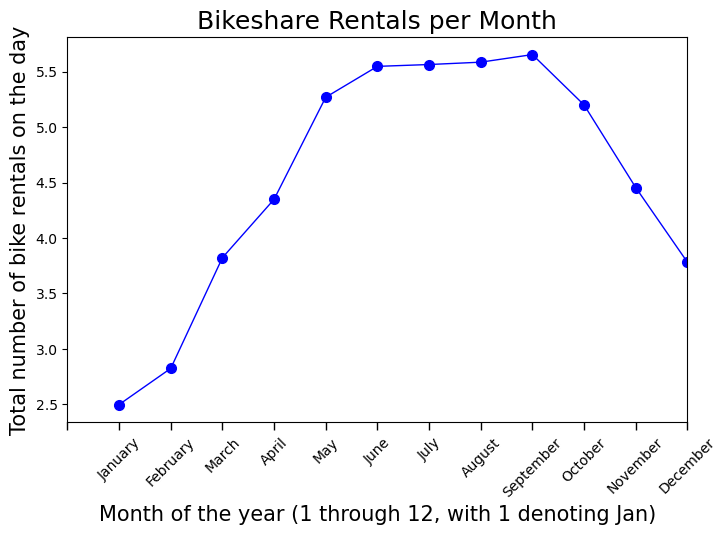

In [27]:
import matplotlib.ticker as ticker
fontsize = 15
fig, ax = plt.subplots(figsize=[8,5])
ax.plot(ave_rentals_month, 'bo-', linewidth=1, markersize=7)

# labels
# ax.set_ylabel('Count (x 1000)', fontsize=fontsize)
# ax.set_xlabel('Month', fontsize=fontsize)

## for more meaningful names
ax.set_xlabel(names_dict['month'], fontsize=fontsize)
ax.set_ylabel(names_dict['count'], fontsize=fontsize)

ax.set_title('Bikeshare Rentals per Month', fontsize=fontsize+3)
ax.yaxis.set_major_formatter(lambda y, pos: y/1000)
ax.xaxis.set_major_locator(ticker.MaxNLocator(12))
ax.xaxis.set_major_formatter(lambda x, pos: calendar.month_name[int(x)])
ax.tick_params(axis='x', rotation=45, length=6, width=1)
plt.xlim([0,12])
plt.show();

In [28]:
bikeshare.temp.unique().shape[0]

50

<a class="anchor" id="split"></a> [TOP](#top)
## 2 - Split the dataset into a training set and a test set

Now that we have an idea of what the data looks like, we want to predict the number of rentals on a given day, i.e. the value of `count`. We will split the data randomly into a **training** and a **testing** set. We will use the `train_test_split` function from `sklearn` ([Scikit learn (sklearn)](https://scikit-learn.org/stable/index.html)).

What is the need for training and testing data sets?
The **training** set will be used to train the model, while the **testing** set will be used to quantify how well that model does on data it has never seen before. 

By setting `random_state` = 42 we ensure reproducibility of your results.

Let us first call a function that will randomly split the data up into a 70-30 split, with 70% of the data going into the training set:
```
from sklearn.model_selection import train_test_split
```

In [29]:
# set the response variable
response = 'count'

In [30]:
# split whole data set
train_data, test_data = train_test_split(bikeshare, test_size=0.30, random_state=42) 

# then create the training feature set (X_train) and the response vector (y_train)
X_train, y_train = train_data.drop(response, axis=1), train_data[response]
X_test, y_test = test_data.drop(response, axis=1), test_data[response]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

print(f'Training set = {train_data.shape[0]} \
({(100*train_data.shape[0]/bikeshare.shape[0]):.2f}% of the total dataset)')
print(f'Testing set  = {test_data.shape[0]} \
({(100*test_data.shape[0]/bikeshare.shape[0]):.2f}% of the total dataset)')

(511, 10) (511,) (220, 10) (220,)
Training set = 511 (69.90% of the total dataset)
Testing set  = 220 (30.10% of the total dataset)


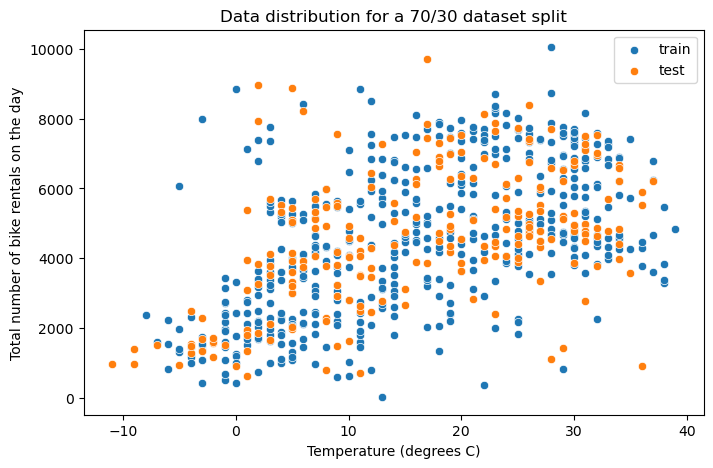

In [31]:
# plot split results 
plt.figure(figsize=[8,5])
sns.scatterplot(data=train_data, x='temp', y='count', label='train')  
sns.scatterplot(data=test_data, x='temp', y='count', label='test') 
plt.xlabel(names_dict['temp'])
plt.ylabel(names_dict['count'])
plt.title("Data distribution for a 70/30 dataset split")
plt.legend()
plt.show()

<div class="alert alert-success">
    <strong>TEAM ACTIVITY 1:</strong> Split the <code>bikeshare</code> data into X_train, y_train, X_test, and y_test but include only <b>one</b> feature ("windspeed")
</div>

In [32]:
# your code here
temp_df = bikeshare[["temp", response]]
train_data, test_data = train_test_split(temp_df, test_size=0.30, random_state=42)


In [33]:
X_train, X_test, y_train, y_test = train_test_split(bikeshare[["temp"]],bikeshare.temp, test_size=0.33)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(489, 1) (242, 1) (489,) (242,)


<a class="anchor" id="sklearn"></a> [TOP](#top)
## 3 - Building a model with `sklearn`

We will work with [scikit-learn (sklearn)](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

```python
import sklearn 
```

According to its website, `Scikit-learn` is an open source machine learning library that supports supervised and unsupervised learning. It also provides various tools for model fitting, data preprocessing, model selection and evaluation, and many other utilities.

#### Why do we need to add a constant in our simple linear regression model? 

Let's say we a data set of two obsevations with one predictor and one response variable each. We would then have the following two equations if we run a simple linear regression model. $$y_1=\beta_0 + \beta_1*x_1$$ $$y_2=\beta_0 + \beta_1*x_2$$ <BR> For simplicity and calculation efficiency we want to "absorb" the constant $b_0$ into an array with $b_1$ so we have only multiplication. To do this we introduce the constant ${x}^0=1$<br>$$y_1=\beta_0*{x_1}^0 + \beta_1*x_1$$ $$y_2=\beta_0 * {x_2}^0 + \beta_1*x_2$$ <BR> That becomes: 
$$y_1=\beta_0*1 + \beta_1*x_1$$ $$y_2=\beta_0 * 1 + \beta_1*x_2$$<bR> 
    
In matrix notation: 
    
$$
\left [
\begin{array}{c}
y_1 \\ y_2 \\
\end{array}
\right] =
\left [
\begin{array}{cc}
1& x_1 \\ 1 & x_2 \\
\end{array}
\right] 
\cdot
\left [
\begin{array}{c}
\beta_0 \\ \beta_1 \\
\end{array}
\right]
$$
<BR><BR>
    
`sklearn` adds the constant for us.
    
### Steps to training a model

#### 1 - Break the sets into one containing the predictor(s) and one with the response variable. Do separately for train and test. 

#### 2 - Define the Model
```
model = sklearn_model_name(hyper_parameter1 = value1, hyper_parameter2 = value2)

```
#### 3 - Scale the features (if needed)
```
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train = pd.DataFrame(X_train_scaled)
X_test = pd.DataFrame(X_test_scaled)
```
#### 4 - Fit Model
```
model.fit(x_train, y_train)
```
#### 5 - Get the Predictions
```
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
```
#### 6 - Evaluate the Model
    
The metrics that you will use to evaluate the model depend on the task at hand, i.e. Regression or Classification. For Regression, $R^2$ Score and $MSE$ are commonly used, while for Classification, Accuracy (%) is one popular metric.
```
# Return the coefficient of determination R^2 of the prediction
r2_train = model.score(y_train, y_pred_train)
r2_test = model.score(y_test, y_pred_test)

# Calculating MSE on the test set
y_pred = model.predict(X_test)
MSE = mean_squared_error(y_test, y_pred)

```
#### 7 - Print Results
```
print("Score for Model (Training):", r2_train)
print("Score for Model (Testing) :", r2_test)
```

### The `scikit-learn` library and the shape of things

Before diving in, let's discuss more of the details of `sklearn`.

`Scikit-learn` consists of **estimators**, Python objects, that implements the methods `fit(X, y)` and `predict()`

Let's see the structure of `scikit-learn` needed to make these fits. `fit()` always takes two arguments:
```python
estimator.fit(Xtrain, ytrain)
```
We will consider two estimators in this lab: `LinearRegression` and `KNeighborsRegressor`.

It is very important to understand that `Xtrain` must be in the form of a **2x2 array** with each row corresponding to one sample, and each column corresponding to the feature values for that sample.

`ytrain` on the other hand is a simple array of responses.  These are continuous for regression problems.

![featurematrix](images/featurematrix.png)

<!--![](images/sklearn2.jpg)-->

This is the reason we write for e.g., 
```
X_train=train_data[['temp']] # two brackets
```
and not 
```
train_data['temp'] # one bracket
```

## $k$-nearest neighbors regression

### Using `sklearn`

We will use `temp` from our available features to predict **total bike rental count**. 

In [34]:
# set the response variable
response = 'count'

In [35]:
# from sklearn.neighbors import KNeighborsRegressor

# split again
train_data, test_data = train_test_split(bikeshare, test_size=0.30, random_state=42) 

# then create the training feature set (X_train) and the response vector (y_train)
X_train = train_data[['temp']] # note the two brackets
y_train = train_data[response] # one bracket
X_test = test_data[['temp']] 
y_test = test_data[response] 
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((511, 1), (511,), (220, 1), (220,))

In [36]:
#from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [37]:
# from sklearn.neighbors import KNeighborsRegressor

# Set kNN hyperparameter:
k = 20

# First, we create the classifier object:
neighbors = KNeighborsRegressor(n_neighbors=k)

# Then, we fit the model using x_train as training data and y_train as target values:
neighbors.fit(X_train, y_train)

# Retrieve our predictions:
prediction_knn = neighbors.predict(X_test)
prediction_train_knn = neighbors.predict(X_train)

# This returns the mean accuracy on the given test data and labels, or in other words, 
# the R squared value -- A constant model that always predicts the expected value of y, 
# disregarding the input features, would get a R^2 score of 1.
r2_train = neighbors.score(X_train, y_train)
r2_test = neighbors.score(X_test, y_test)
mse_test = mean_squared_error(y_test, prediction_knn)
mse_train = mean_squared_error(y_train, prediction_train_knn)

print(f'------ kNN model score for k = {k}')
print(f'R2 training set: {r2_train:.3f}')
print(f'R2 testing set: {r2_test:.3f}')
print(f'MSE training set: {mse_train:.2f}')
print(f'MSE testing set: {mse_test:.2f}')

------ kNN model score for k = 20
R2 training set: 0.357
R2 testing set: 0.238
MSE training set: 2714575.98
MSE testing set: 2863935.34


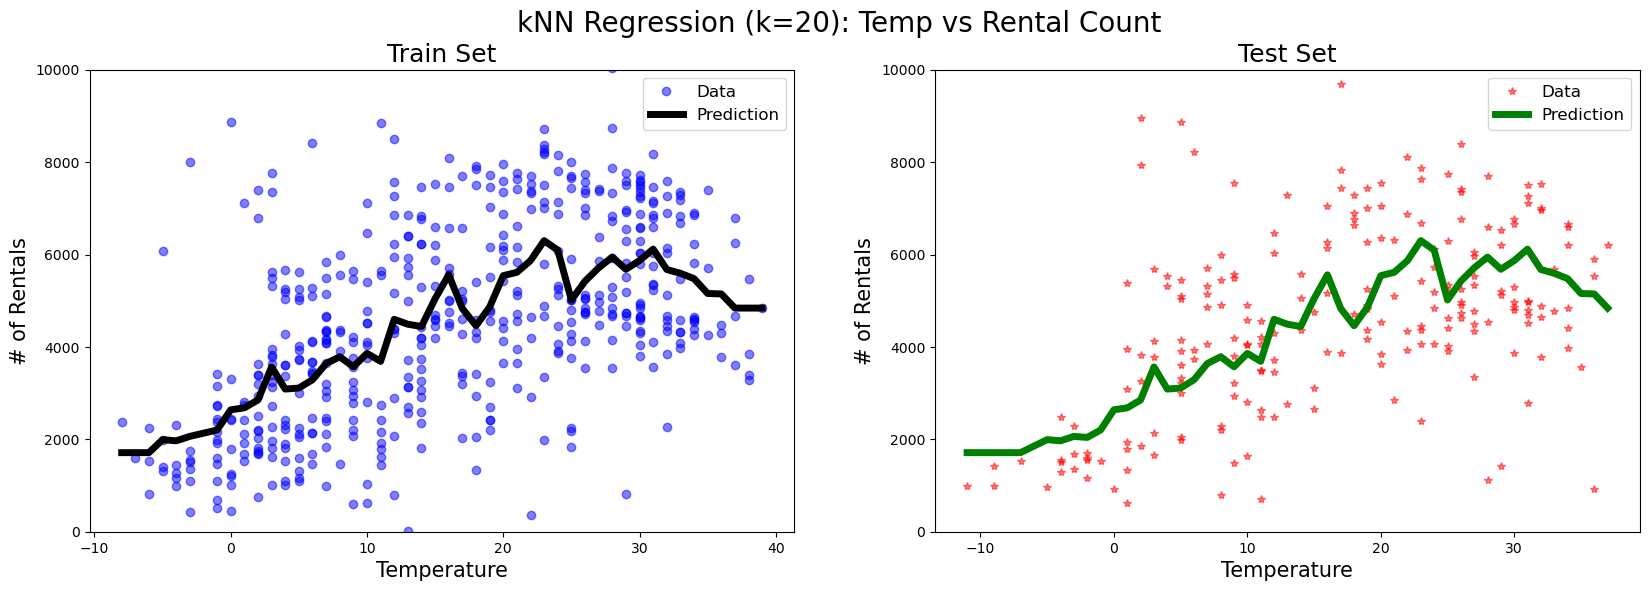

In [38]:
# SubPlots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

# train data
axes[0].set_ylim([0,10000])
axes[0].plot(train_data['temp'], train_data['count'], 'bo', alpha = 0.5, label = 'Data' )

sorted_temp = train_data.sort_values(['temp'])
prediction_knn = neighbors.predict(sorted_temp[['temp']])

axes[0].plot(sorted_temp['temp'], prediction_knn, 'k-', linewidth = 5, markersize = 10, label = 'Prediction')
axes[0].set_xlabel('Temperature', fontsize = 15)
axes[0].set_ylabel('# of Rentals', fontsize = 15)
axes[0].set_title("Train Set", fontsize = 18)
axes[0].legend(loc = 'upper right', fontsize = 12)

# test data
axes[1].set_ylim([0,10000])
axes[1].plot(test_data['temp'], test_data['count'],'r*', alpha = 0.5, label = 'Data' )

sorted_temp = test_data.sort_values(['temp'])
prediction_knn = neighbors.predict(sorted_temp[['temp']])

axes[1].plot(sorted_temp['temp'], prediction_knn, 'g-', linewidth = 5, markersize = 10, label = 'Prediction')
axes[1].set_xlabel('Temperature', fontsize = 15)
axes[1].set_ylabel('# of Rentals', fontsize = 15)
axes[1].set_title("Test Set", fontsize = 18)
axes[1].legend(loc = 'upper right', fontsize = 12)

fig.suptitle("kNN Regression (k={}): Temp vs Rental Count".format(k), fontsize = 20)
plt.show()

<div class="alert alert-success">
    <strong>TEAM ACTIVITY 2:</strong> Practice using sklearn's kNN regression
</div>
    
 - Let's now try different $k$s for our model. 

1. Load a simple dataset `sim_data.csv`
1. Perform 80-20 train-test split using a random state of 42 
1. Create a function that implements kNN regression with your choice of k (explore a few different k's)
1. Predict on both training and test data
1. For all kNN models generated, plot plot for the test and train set next to one other:
1. Calculate $R^2$ score 

*Hints:*
- dont forget to sort!
- you can make plot colors more transparent using "alpha" and lines thicker using "linewidth"

R2 training set: 1.000
R2 testing set: -0.365


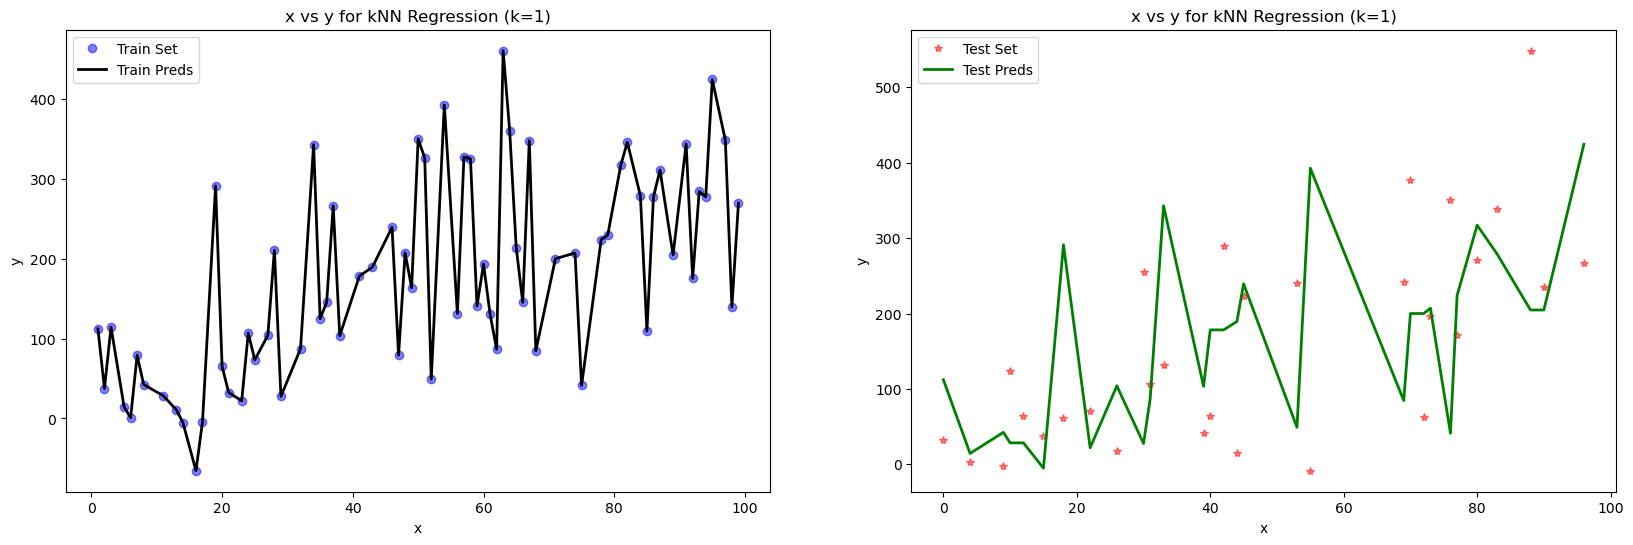

R2 training set: 0.677
R2 testing set: 0.186


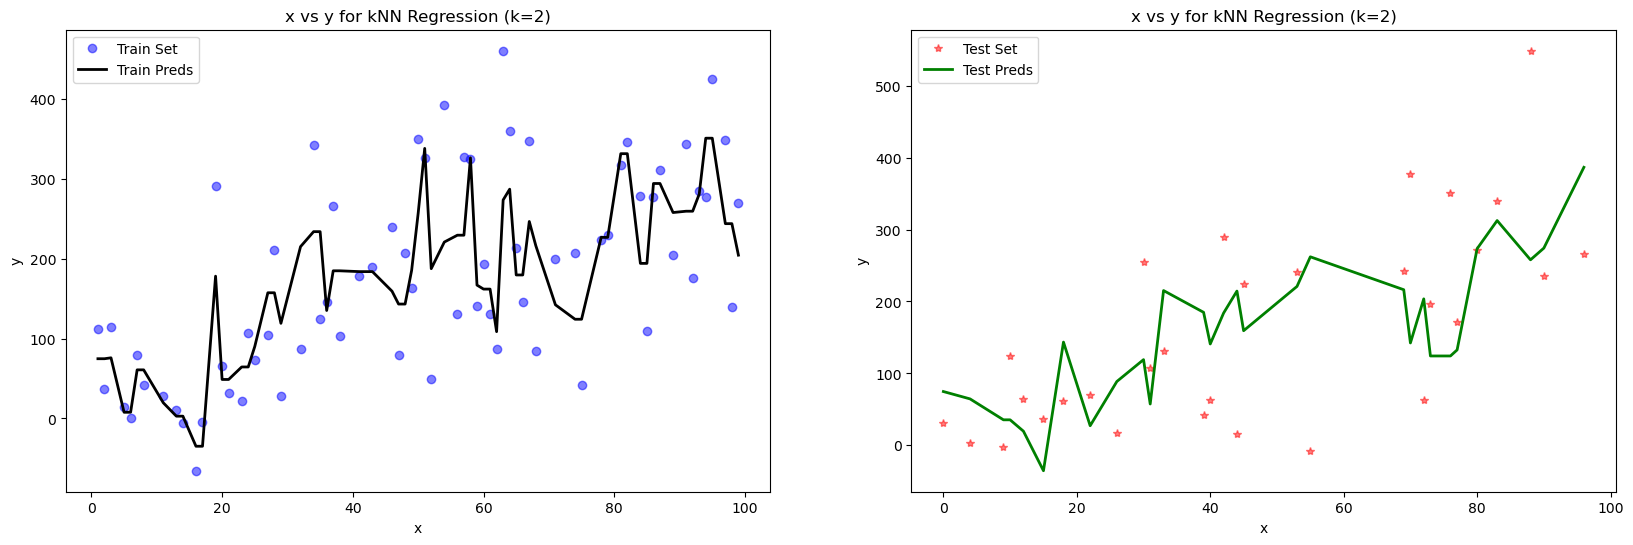

R2 training set: 0.476
R2 testing set: 0.396


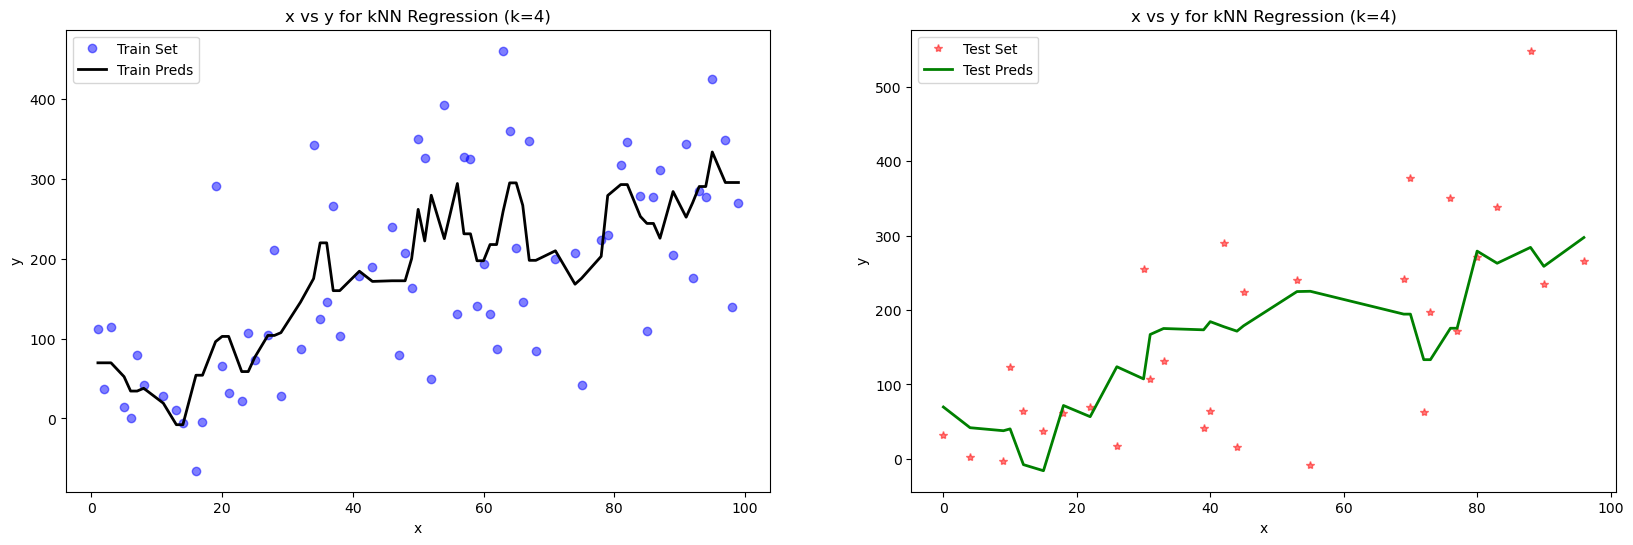

R2 training set: 0.433
R2 testing set: 0.418


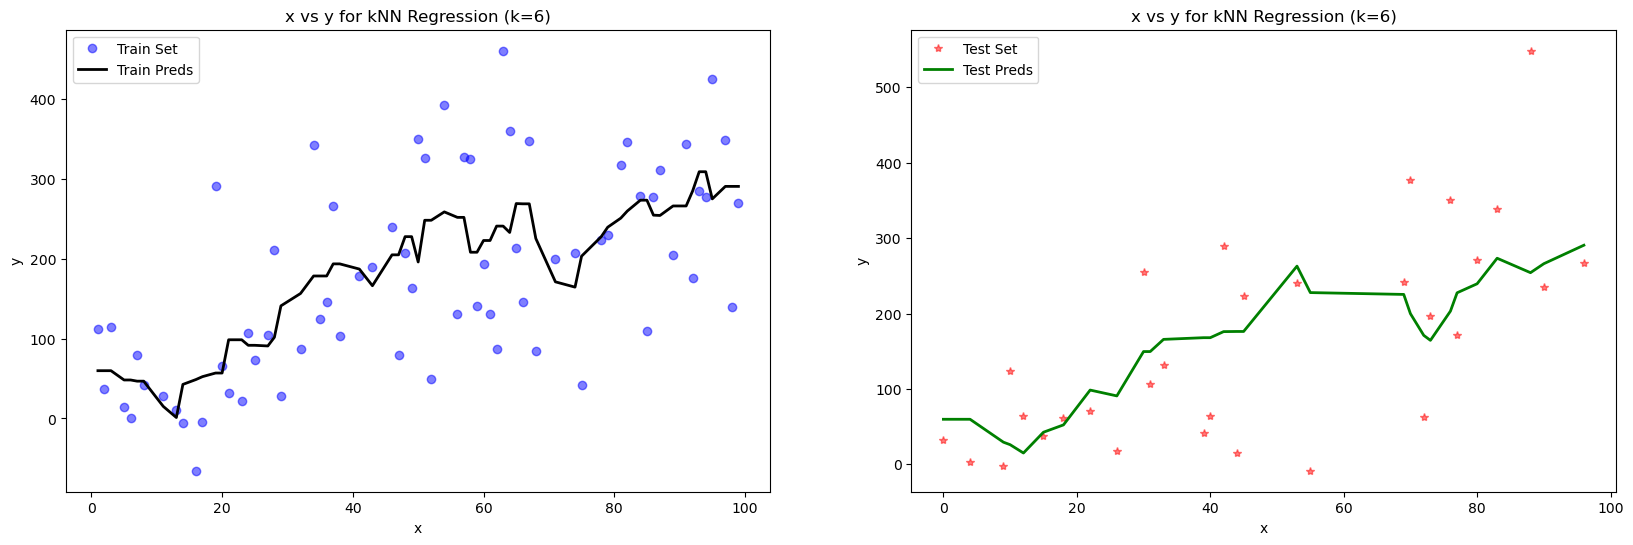

R2 training set: 0.452
R2 testing set: 0.363


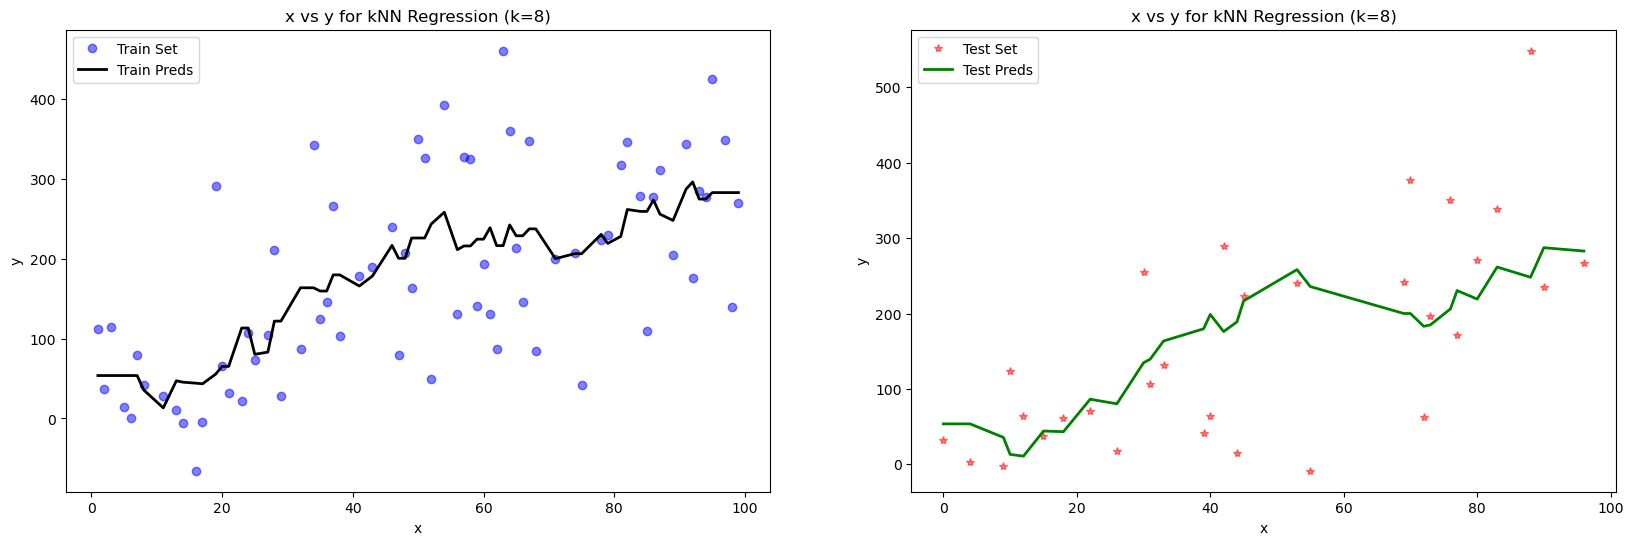

R2 training set: 0.428
R2 testing set: 0.386


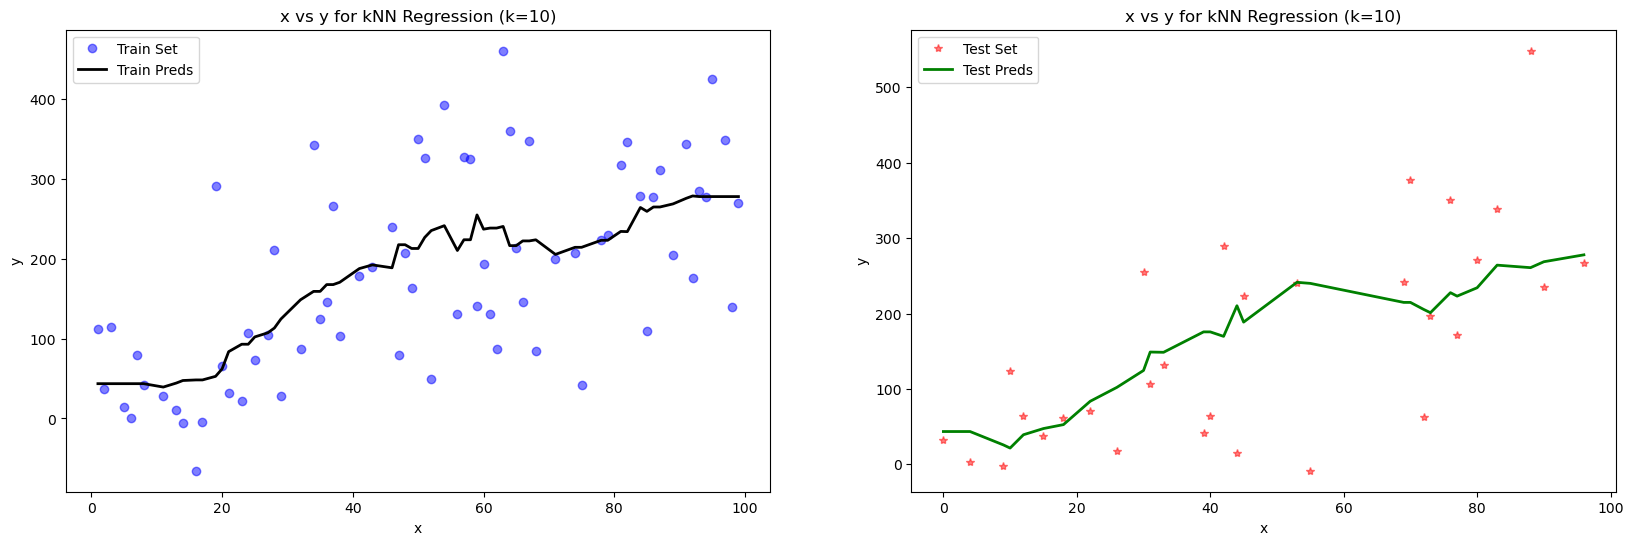

R2 training set: 0.440
R2 testing set: 0.388


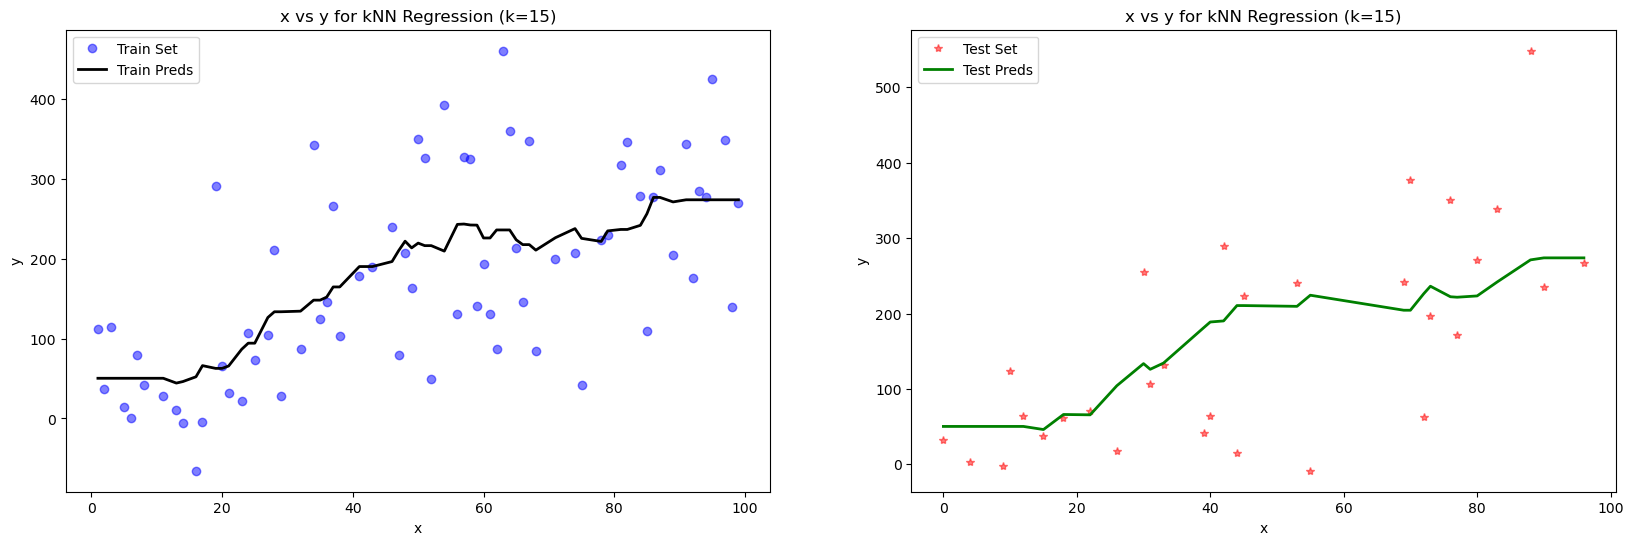

R2 training set: 0.424
R2 testing set: 0.391


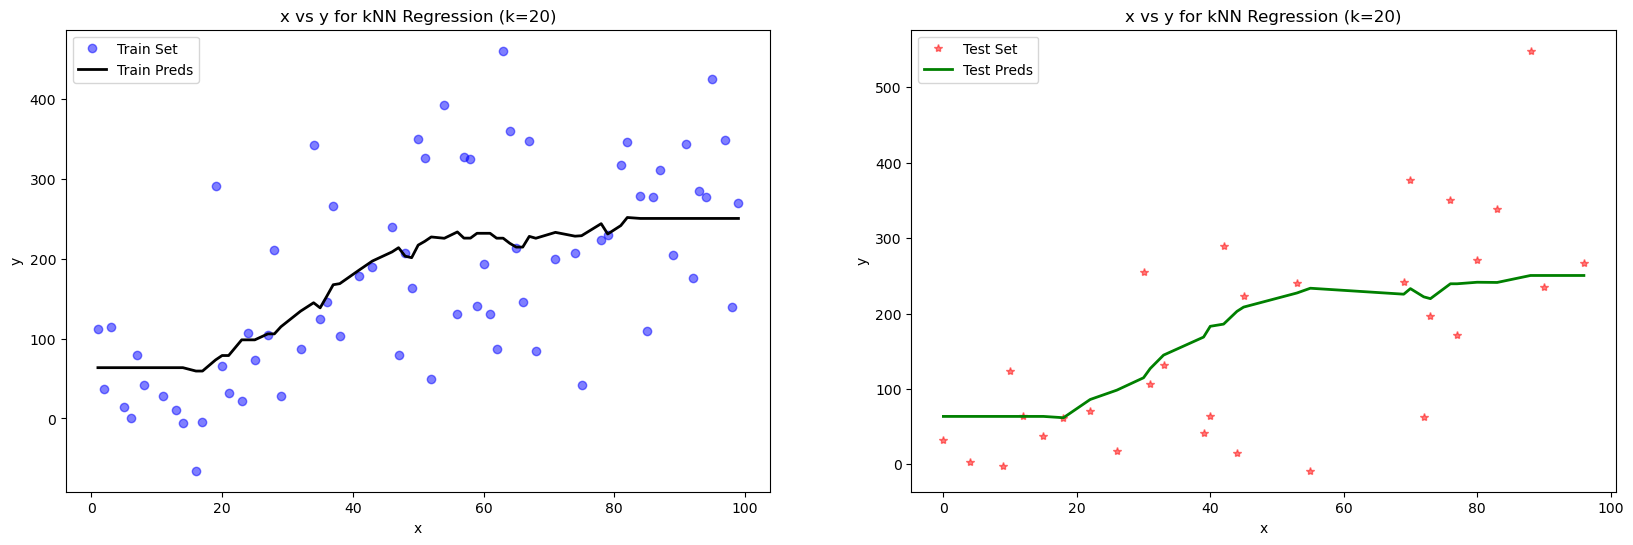

R2 training set: 0.376
R2 testing set: 0.360


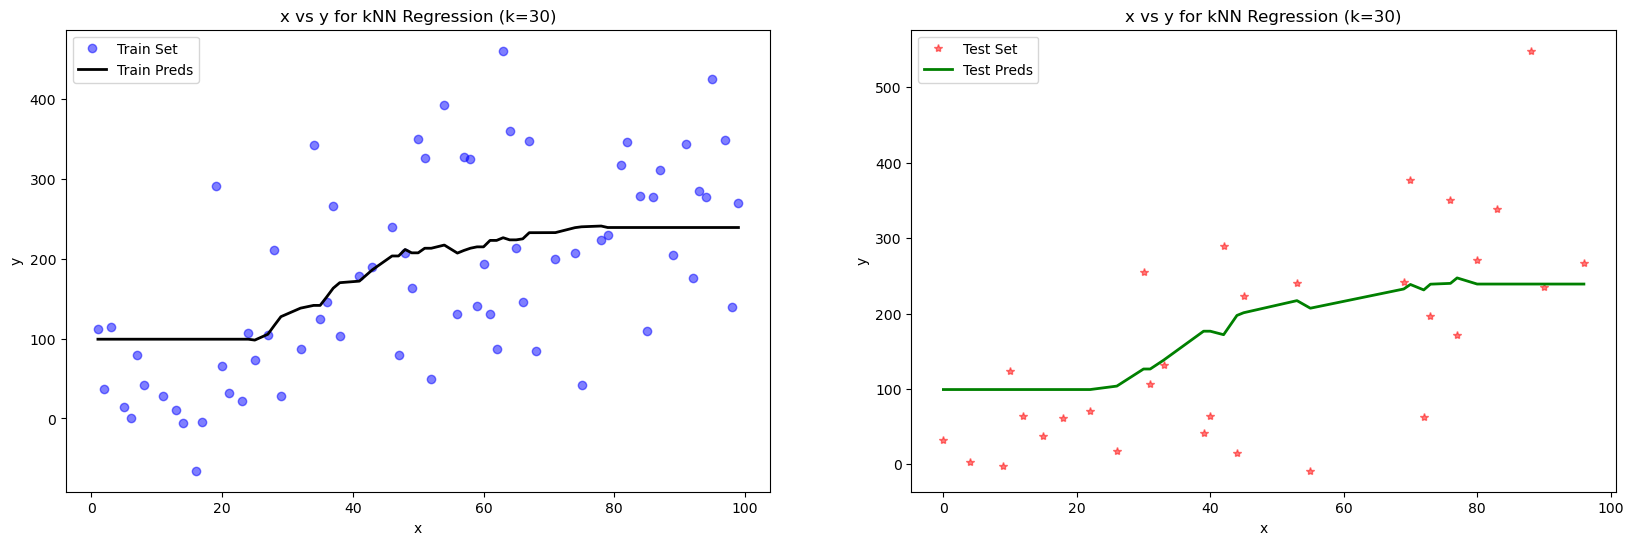

In [39]:
# read in data
data = pd.read_csv("data/sim_data.csv")

# drop Unnamed column
data.drop(columns=["Unnamed: 0"], inplace=True)

# split into 70/30, random_state=42
sim_train_data, sim_test_data = train_test_split(data, test_size=0.3, random_state=42)

def knn_model(k, train_data, test_data):
    # create the classifier object
    neighbors = KNeighborsRegressor(n_neighbors=k)

    # fit the model using x_train as training data and y_train as target values
    neighbors.fit(train_data[['x']], train_data['y'])

    sorted_train = train_data.sort_values(['x'])
    sorted_test = test_data.sort_values(['x'])

    # Retreieve our predictions:
    train_preds = neighbors.predict(sorted_train[['x']])
    test_preds = neighbors.predict(sorted_test[['x']])
    
    # find r^2
    r2_train = neighbors.score(train_data[['x']], train_data['y'])
    r2_test = neighbors.score(test_data[['x']], test_data['y'])
    
    print(f'R2 training set: {r2_train:.3f}')
    print(f'R2 testing set: {r2_test:.3f}')
    return sorted_train, sorted_test, train_preds, test_preds, r2_train, r2_test

def plot_predictions_same_plot(k, train_data,test_data, train_preds, test_preds):
    fig, axes = plt.subplots(1, 2, figsize=(20,6))

    # train data
    
    axes[0].plot(train_data['x'], train_data['y'], 'bo', alpha = 0.5, label = 'Train Set' )
    axes[0].plot(train_data['x'], train_preds, 'k-', linewidth = 2, markersize = 10, label = 'Train Preds')
    axes[1].plot(test_data['x'], test_data['y'], 'r*', alpha = 0.5, label = 'Test Set' )
    axes[1].plot(test_data['x'], test_preds, 'g-', linewidth = 2, markersize = 10, label = 'Test Preds')

    for i in [0,1]:
        axes[i].set_xlabel('x')
        axes[i].set_ylabel('y')
        axes[i].set_title(f'x vs y for kNN Regression (k={k})')
        axes[i].legend()
    plt.show()

    fig.suptitle('THIS', fontsize = 20)
    #plt.show()

knn_train_preds = []
knn_test_preds = []
knn_r2_train_scores = []
knn_r2_test_scores = []

list_of_ks = [1,2,4,6,8,10,15,20,30]

for k in list_of_ks:
    sim_sorted_train, sim_sorted_test, sim_train_preds, sim_test_preds, knn_r2_train, knn_r2_test = knn_model(k, sim_train_data,sim_test_data)
    plot_predictions_same_plot(k,sim_sorted_train, sim_sorted_test, sim_train_preds, sim_test_preds)
    knn_train_preds.append(sim_train_preds)
    knn_test_preds.append(sim_test_preds)
    knn_r2_train_scores.append(knn_r2_train)
    knn_r2_test_scores.append(knn_r2_test)

## Linear Regression

We just went over the kNN prediction method. Now, we will fit the same data using a linear regression model. 

**What is the main difference between a kNN model and linear regression model?** Linear regression specifies the model (whatever the data is, the model will fit a linear line) whereas kNN does not specify a model, it just assigns a value based on how close this value is to k points in the training set (based on some **closeness** metric). 

Advantages of linear regression models are that they are very fast and yield an exact optimal solution. For a more in-depth discussion on generalized linear models, please see the Advanced Section on this.

We will use the same training/testing dataset as before and create linear regression objects. We can do this using sklearn (as we did for kNN) as well as with another package called [statsmodels](https://www.statsmodels.org/stable/index.html).

In [40]:
response = 'count'
# Label data as X,Y for ease
x_train, y_train = train_data[['temp']], train_data[response]
x_test, y_test = test_data[['temp']], test_data[response]

You can also split into train test by x and y using train test split

X_train, X_test, y_train, y_test = train_test_split( bikeshare['temp']), bikeshare['count'] )

## Linear Regression using [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

In [41]:
from sklearn.linear_model import LinearRegression

lr_sklearn = LinearRegression().fit(x_train, y_train) # x data must be 2D array
print('Coefficients:', lr_sklearn.coef_)
print('Intercept:', lr_sklearn.intercept_)

Coefficients: [94.82327417]
Intercept: 2996.28697323997


*Note:* only one coefficient here since only using one descriptor variable (`temp`)

**Use model to predict on training and testing data and plot prediction**

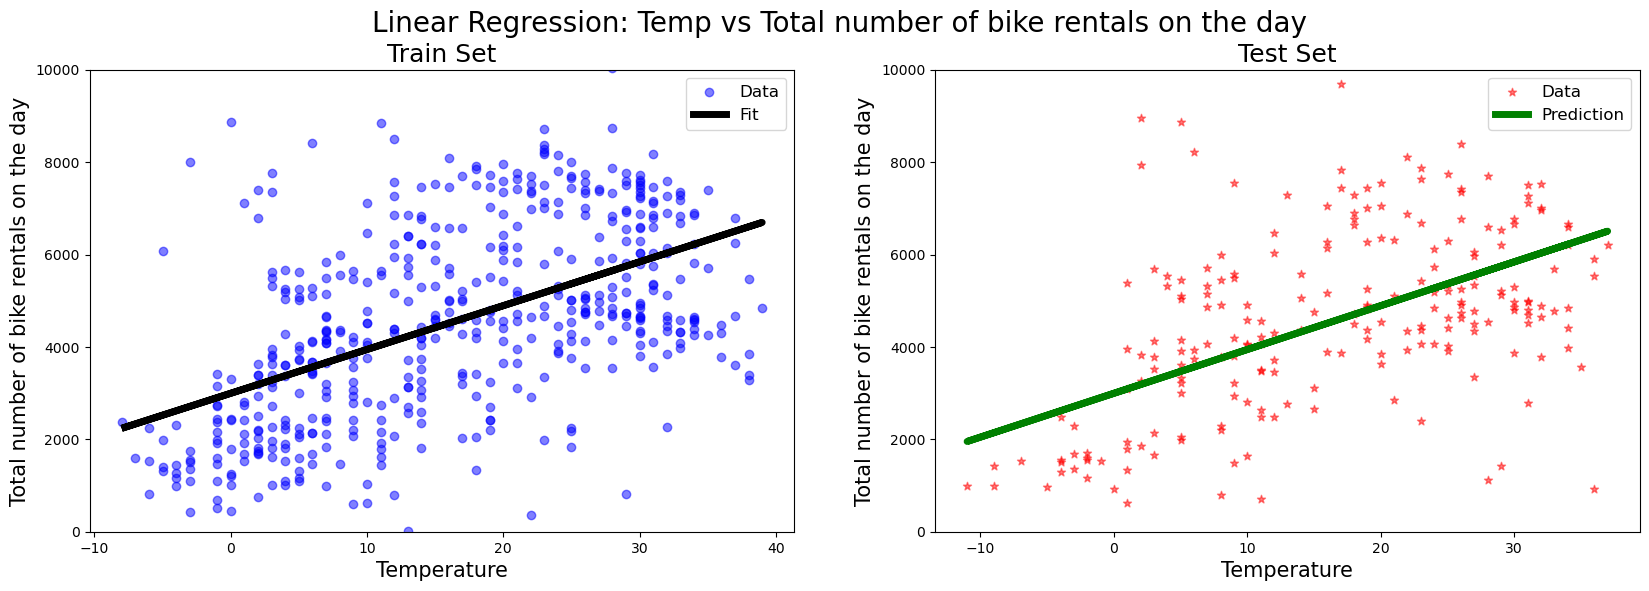

In [42]:
# predict
y_preds_train = lr_sklearn.predict(x_train)
y_preds_test = lr_sklearn.predict(x_test)

# plot predictions
fig, axes = plt.subplots(1,2,figsize=(20,6))
axes = axes.ravel()

axes[0].scatter(x_train, y_train, color = 'b', alpha = 0.5, label = 'Data')
axes[0].plot(x_train, y_preds_train, 'k', linewidth = 5, label = 'Fit')
axes[0].set_title('Train Set', fontsize = 18)
axes[1].scatter(x_test, y_test, color = 'r',marker='*', alpha = 0.5, label = 'Data')
axes[1].plot(x_test, y_preds_test, 'g', linewidth = 5, label = 'Prediction')
axes[1].set_title('Test Set', fontsize = 18)

for i, ax in enumerate(axes):
    ax.set_ylim(0,10000)
    ax.set_xlabel('Temperature', fontsize = 15)
    ax.set_ylabel(names_dict[response], fontsize = 15)
    ax.legend(loc = 'upper right', fontsize = 12)

fig.suptitle(f'Linear Regression: Temp vs {names_dict[response]}', fontsize = 20)
plt.show()

**Compute performance metrics for both training and testing**

In [43]:
# from sklearn import metrics

# Mean Squared Error (MSE)
print("MSE Train: {:.3f}".format(metrics.mean_squared_error(y_train, y_preds_train)))
print("MSE Test: {:.3f}".format(metrics.mean_squared_error(y_test, y_preds_test)))

# R^2 score
print("R^2 Train: {:.3f}".format(metrics.r2_score(y_train, y_preds_train)))
print("R^2 Test: {:.3f}".format(metrics.r2_score(y_test, y_preds_test)))

MSE Train: 3031302.440
MSE Test: 2915373.463
R^2 Train: 0.282
R^2 Test: 0.224


### Residual plots

Residual plots are useful for identifying non-linearity between the predictors and the response variable. 

- After we fit our model, we calculate the predicted (of *fitted*) values $\hat{y}_{i}$.
- Then we calculate the residuals $e_i = y_i - \hat{y}_{i}$
- We plot the residuals $e_1$ versus: 
     - the predictor $x_i$, if we have one predictor in our model, **OR** 
     - the predicted values $\hat{y}_{i}$, if we have multiple predictors.

<div class="alert alert-success">
    <strong>TEAM ACTIVITY 3: Plot the residuals</strong>
</div>

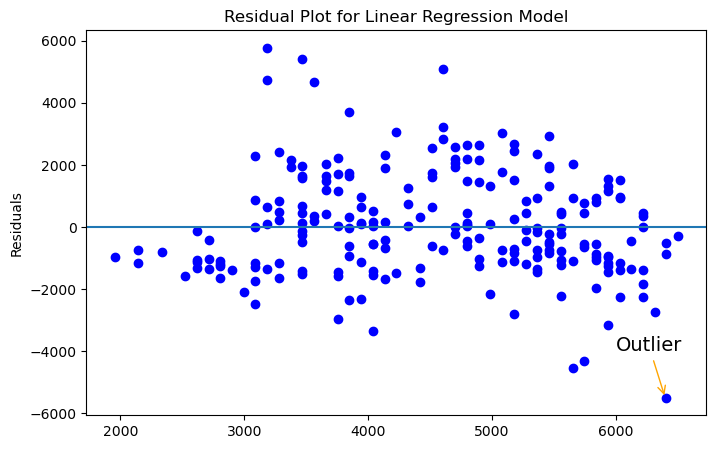

In [44]:
# plot the residuals
y_pred = lr_sklearn.predict(test_data[['temp']]) # predicted (fitted) values
y = test_data[response]                         # test values
residuals = y-y_pred
fig, axes = plt.subplots(1,1,figsize=(8,5))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline()
plt.title("Residual Plot for Linear Regression Model")
plt.annotate('Outlier', xy=(6400,-5500), xytext=(6000,-4000), fontsize=14,
            arrowprops=dict(arrowstyle='->', ec='orange', lw=1)) #, bbox = dict(boxstyle="round", fc="0.8"))
plt.ylabel('Residuals');

In [45]:
# find the outliers
test_data[(residuals<-5000) | (residuals>5500)] 

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
333,2,6,0,4,1,2,36.0,37.0,56.83,0.15,915
533,1,1,0,5,1,1,2.0,5.0,50.75,0.38,8961


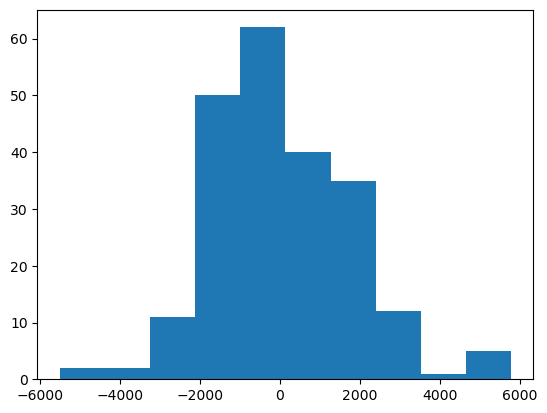

In [46]:
plt.hist(residuals);

Recall that more accurate models will have higher $R^2$ scores (value of 1 is perfect fitted line) and lower MSEs (meaning lower error). For more info on these, check out sklearn [metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) documentation. Take a look at the end of the notebook for calculations of MSE and $R^2$ metrics by hand.

<div class="alert alert-success">
    <strong>TEAM ACTIVITY 4: Compare kNN and linear regression for the same dataset</strong>
</div>

1. For the `sim_data` dataset, split 70-30 train-test split and use random state of 42 
1. Create a function that implements linear regression with sklearn 
1. Predict on both training and test data
1. Create 2 subplots with the following plotted:
    - Subplot 1: Train set
        - Plot training data in blue
        - Plot linear regression prediction in black
        - Plot kNN prediction (using k = 10) in magenta ('m')
    - Subplot 2: Test set
        - Plot testing data in red
        - Plot linear regression prediction in green
        - Plot kNN prediction (using k = 10) in yellow ('y') 
1. Calculate $MSE$ scores for both train and test sets for both kNN and linear regression 

*Hints:*
- don't forget sort!
- plt.subplots(...) creates subplots

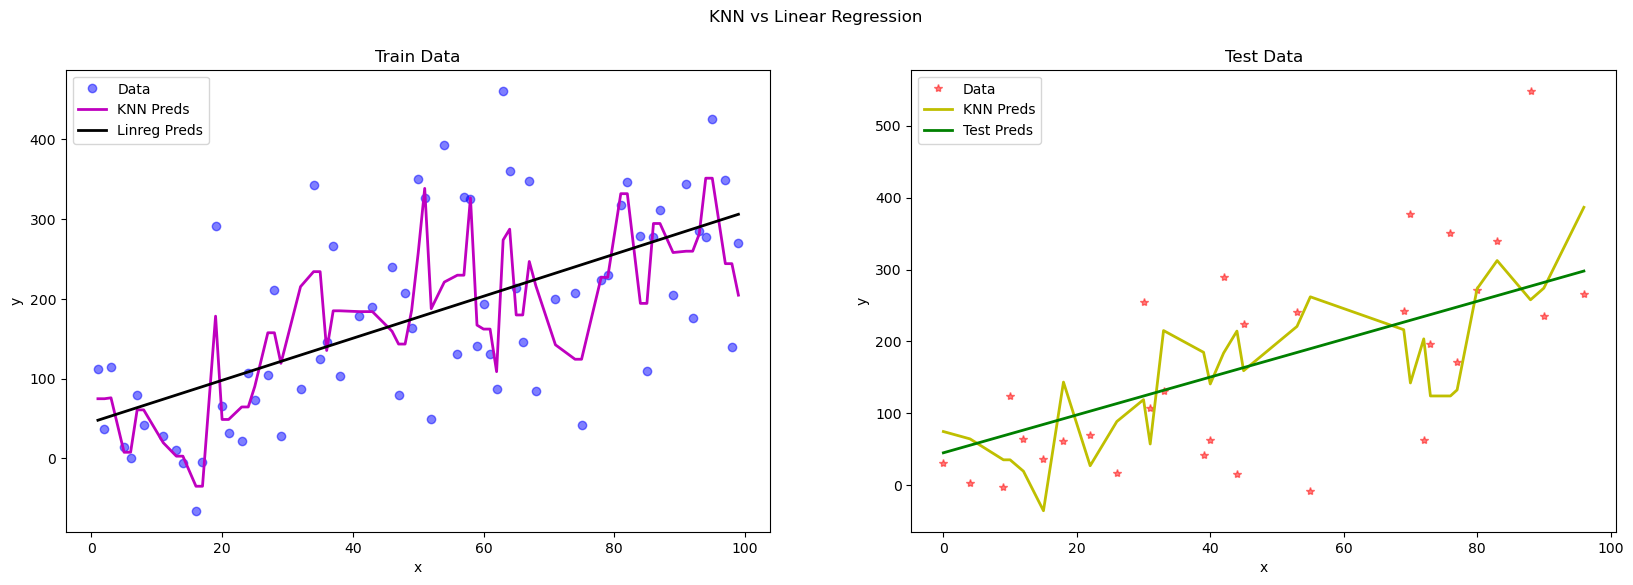

R^2 Score of kNN on training set with k=10: 0.6771110489795626
R^2 Score of kNN on testing set: with k=10 0.18621216784868266
R^2 Score of linear regression on training set 0.3816018646727135
R^2 Score of linear regression on testing set 0.46326892325303615


In [47]:
def linreg_model(train_data,test_data):
    # sort
    sorted_train = train_data.sort_values(['x'])
    sorted_test = test_data.sort_values(['x'])

    x_train, x_test, y_train, y_test = sorted_train['x'], sorted_test['x'], sorted_train['y'], sorted_test['y']

    x_train_ca = x_train.values.reshape(-1,1)
    x_test_ca = x_test.values.reshape(-1,1)
    
    # Create Linear Regression object
    results = LinearRegression().fit(x_train_ca, y_train)

    # predict
    train_preds = results.predict(x_train_ca)
    test_preds = results.predict(x_test_ca)
    
    # find r^2
    r2_train = metrics.r2_score(y_train, results.predict(x_train_ca))
    r2_test = metrics.r2_score(y_test, results.predict(x_test_ca))
    
    return train_preds, test_preds, r2_train, r2_test

def plot_predictions2(k,train_data,test_data, knn_train_preds, knn_test_preds, linreg_train_preds, linreg_test_preds):

    # SubPlots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
    axes[0].plot(train_data['x'], train_data['y'], 'bo',alpha = 0.5, label = 'Data' )
    axes[0].plot(train_data['x'], knn_train_preds,'m-', linewidth = 2, markersize = 10,  label = 'KNN Preds')
    axes[0].plot(train_data['x'], linreg_train_preds,'k-', linewidth = 2, markersize = 10, label = 'Linreg Preds')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')
    axes[0].set_title("Train Data")
    axes[0].legend()

    axes[1].plot(test_data['x'], test_data['y'], 'r*', alpha = 0.5, label = 'Data' )
    axes[1].plot(test_data['x'], knn_test_preds, 'y-', linewidth = 2, markersize = 10, label = 'KNN Preds')
    axes[1].plot(test_data['x'], linreg_test_preds, 'g-', linewidth = 2, markersize = 10,label = 'Test Preds')
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('y')
    axes[1].set_title("Test Data")
    axes[1].legend()

    fig.suptitle("KNN vs Linear Regression")
    plt.show()

# get predictions
linreg_train_preds,linreg_test_preds, linreg_r2_train, linreg_r2_test = linreg_model(sim_train_data,sim_test_data)

# plot linreg predictions side by side with knn predictions
k=10
plot_predictions2(k, sim_sorted_train, sim_sorted_test, knn_train_preds[1], knn_test_preds[1], linreg_train_preds, linreg_test_preds)

# print r2 scores for knn with k=10 and linreg
print("R^2 Score of kNN on training set with k={}:".format(k), knn_r2_train_scores[1])
print("R^2 Score of kNN on testing set: with k={}".format(k), knn_r2_test_scores[1])
print("R^2 Score of linear regression on training set", linreg_r2_train)
print("R^2 Score of linear regression on testing set", linreg_r2_test)

## END of lab

## Bonus Material: Train-Test Split using a mask

In [48]:
#Function to Split data into Train and Test Set
def split_data(data):
    
    #Calculate Length of Dataset
    length = len(data)
    
    #Define Split
    split = 0.7
    
    #Set a random Seed For Shuffling
    np.random.seed(9001)
    
    #Generate a Mask with a X:Y Split
    mask = np.random.rand(length) < split
    
    #Separate train and test data
    data_train = data[mask]
    data_test = data[~mask]
    
    #Return Separately
    return data_train, data_test

In [49]:
#Split data using defined function
train_data_manual, test_data_manual = split_data(bikeshare)
print("Length of Training set:",len(train_data_manual))
print("Length of Testing set:",len(test_data_manual))

Length of Training set: 507
Length of Testing set: 224


In [50]:
## Check that the ratio between test and train sets is right
test_data_manual.shape[0]/(test_data_manual.shape[0]+train_data_manual.shape[0])

0.3064295485636115

## Extra: Implementing the kNN Algorithm by hand 🏋🏻‍♂️

To really understand how the kNN algorithm works, it helps to go through the algorithm line by line in code.

In [51]:
#kNN Algorithm
def knn_algorithm(train, test, k):
    
    #Create any empty list to store our predictions in
    predictions = []
    
    #Separate the response and predictor variables from training and test set:
    train_x = train['temp']
    train_y = train['count']
    test_x  = test['temp']
    test_y  = test['count']
    
    for i, ele in enumerate(test_x):
        
        #For each test point, store the distance between all training points and test point
        distances = pd.DataFrame((train_x.values - ele)**2 , index=train.index)
        distances.columns =['dist']
        
        #display(distances)
        #Then, we sum across the columns per row to obtain the Euclidean distance squared
        ##distances = vec_distances.sum(axis = 1)
        
        #Sort the distances to training points (in ascending order) and take first k points
        nearest_k = distances.sort_values(by='dist').iloc[:k]
        
        #For simplicity, we omitted the square rooting of the Euclidean distance because the
        #square root function preserves order. 
        
        #Take the mean of the y-values of training set corresponding to the nearest k points
        k_mean = train_y[nearest_k.index].mean()
        
        #Add on the mean to our predicted y-value list
        predictions.append(k_mean)
    
    #Create a dataframe with the x-values from test and predicted y-values  
    predict = test.copy()  
    predict['predicted_count'] = pd.Series(predictions, index=test.index)
    
    return predict

Now to run the algorithm on our dataset with $k = 5$:

In [52]:
#Run the kNN function 

k = 5
predicted_knn = knn_algorithm(train_data, test_data, k)
predicted_knn.head()

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count,predicted_count
703,3,7,0,2,1,1,34.0,33.0,49.21,0.13,6660,5269.2
33,4,11,0,6,0,1,6.0,9.0,51.92,0.19,3926,2958.6
300,2,6,0,1,1,2,21.0,23.0,77.79,0.17,5099,5577.4
456,4,12,0,4,1,1,2.0,5.0,58.00,0.24,7938,2377.2
633,2,5,0,0,0,2,20.0,23.0,74.00,0.15,6359,4693.4


We want to have a way to evaluate our predictions from the kNN algorithm with $k=5$. One way is to compute the $R^2$ coefficient. Let's create a function for that:

In [53]:
#Test predictions in comparison to true value of test set
def evaluate(predicted, true):
    
    #Find the squared error:
    squared_error = (predicted['predicted_count'] - true['count'])**2
    
    #Finding the mean squared error:
    error_var = squared_error.sum()
    sample_var = ((true['count'] - true['count'].mean())**2).sum()
    r = (1 - (error_var / sample_var))
    return r

Then let's apply this function to our predictions:

In [54]:
print("Length of Test Data:",len(test_data))
print("R^2 Score of kNN test:", evaluate(predicted_knn, test_data))

Length of Test Data: 220
R^2 Score of kNN test: 0.15616203314647292


In [55]:
predicted_knn_train = knn_algorithm(test_data, train_data, k)
print("R^2 Score of kNN train:", evaluate(predicted_knn_train, train_data))

R^2 Score of kNN train: 0.14054289261925446


## Extra: `pandas` tricks

In [57]:
# seasons and months overlap
pd.set_option('display.max_rows', None)
bikeshare.groupby(['season', 'month'], observed=True).size()

season  month
1       1        62
        2        57
        3        40
        12       22
2       3        22
        4        60
        5        62
        6        40
3       6        20
        7        62
        8        62
        9        44
4       9        16
        10       62
        11       60
        12       40
dtype: int64

<div class='exercise'> <b> Exercise: Look at the table above.</b> Do you notice anything strange?</div>

#### answer
What is the connection between seasons and months? 
Depends on which definition you use and if you are north or south of the equator. 
For more details see [Seasons: Meteorological and Astronomical](#https://www.timeanddate.com/calendar/aboutseasons.html)

#### How to change values in specific places in the dataframe
1. create a mask to change values to individual rows
2. change the value by applying a function to all the rows

Apply a function: `.apply(lambda row: funct(row, *args))`

In [58]:
show_names_dict = {1: 'work', 0:'fun'}

In [59]:
## OPTIONAL EXAMPLE on how to create a new column by applying a function to the rows
# def my_function(df, column1, column2, .... more columns):
#     s = df[column1]  
#     b = df[column2] 
#     ## OR some complicated function of s and b
#     return np.round(s*b, PRECISION)

# df[new_column_name] = df.apply(lambda row: my_function(row, column1, column2), axis=1)

In [60]:
# we are making a copy so not to change our initial dataframe
df = bikeshare.copy()
mask = (df.workingday==1)
# change only the rows with workingday==1
# df.loc[mask, 'workingday'] = \
#      df.loc[mask, 'workingday'].apply(lambda row: show_names_dict[row])

# change all the rows
df['workingday'] = \
     df['workingday'].apply(lambda row: show_names_dict[row])
df.head()

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
0,2,5,0,2,work,2,24.0,26.0,76.58,0.12,6073
1,4,12,0,2,work,1,15.0,19.0,73.38,0.17,6606
2,2,6,0,4,work,1,26.0,28.0,56.96,0.25,7363
3,4,12,0,0,fun,1,0.0,4.0,58.63,0.17,2431
4,3,9,0,3,work,3,23.0,23.0,91.71,0.10,1996
